Solar Energy Production Prediction System
Supporting SDG 7: Affordable and Clean Energy
Data loaded successfully. Shape: (10000, 12)
Starting data wrangling...
Missing values before cleaning:
DATE_TIME              0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
HUMIDITY               0
WIND_SPEED             0
HOUR                   0
MONTH                  0
DAY_OF_YEAR            0
SEASON                 0
DC_POWER               0
AC_POWER               0
dtype: int64
Outliers handled in AMBIENT_TEMPERATURE: 83
Outliers handled in MODULE_TEMPERATURE: 83
Outliers handled in IRRADIATION: 0
Outliers handled in DC_POWER: 652
Data wrangling completed successfully!
Performing Exploratory Data Analysis...

Dataset Overview:
Shape: (10000, 12)
Data types:
DATE_TIME              datetime64[ns]
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
HUMIDITY                      float64
WIND_SPEED          

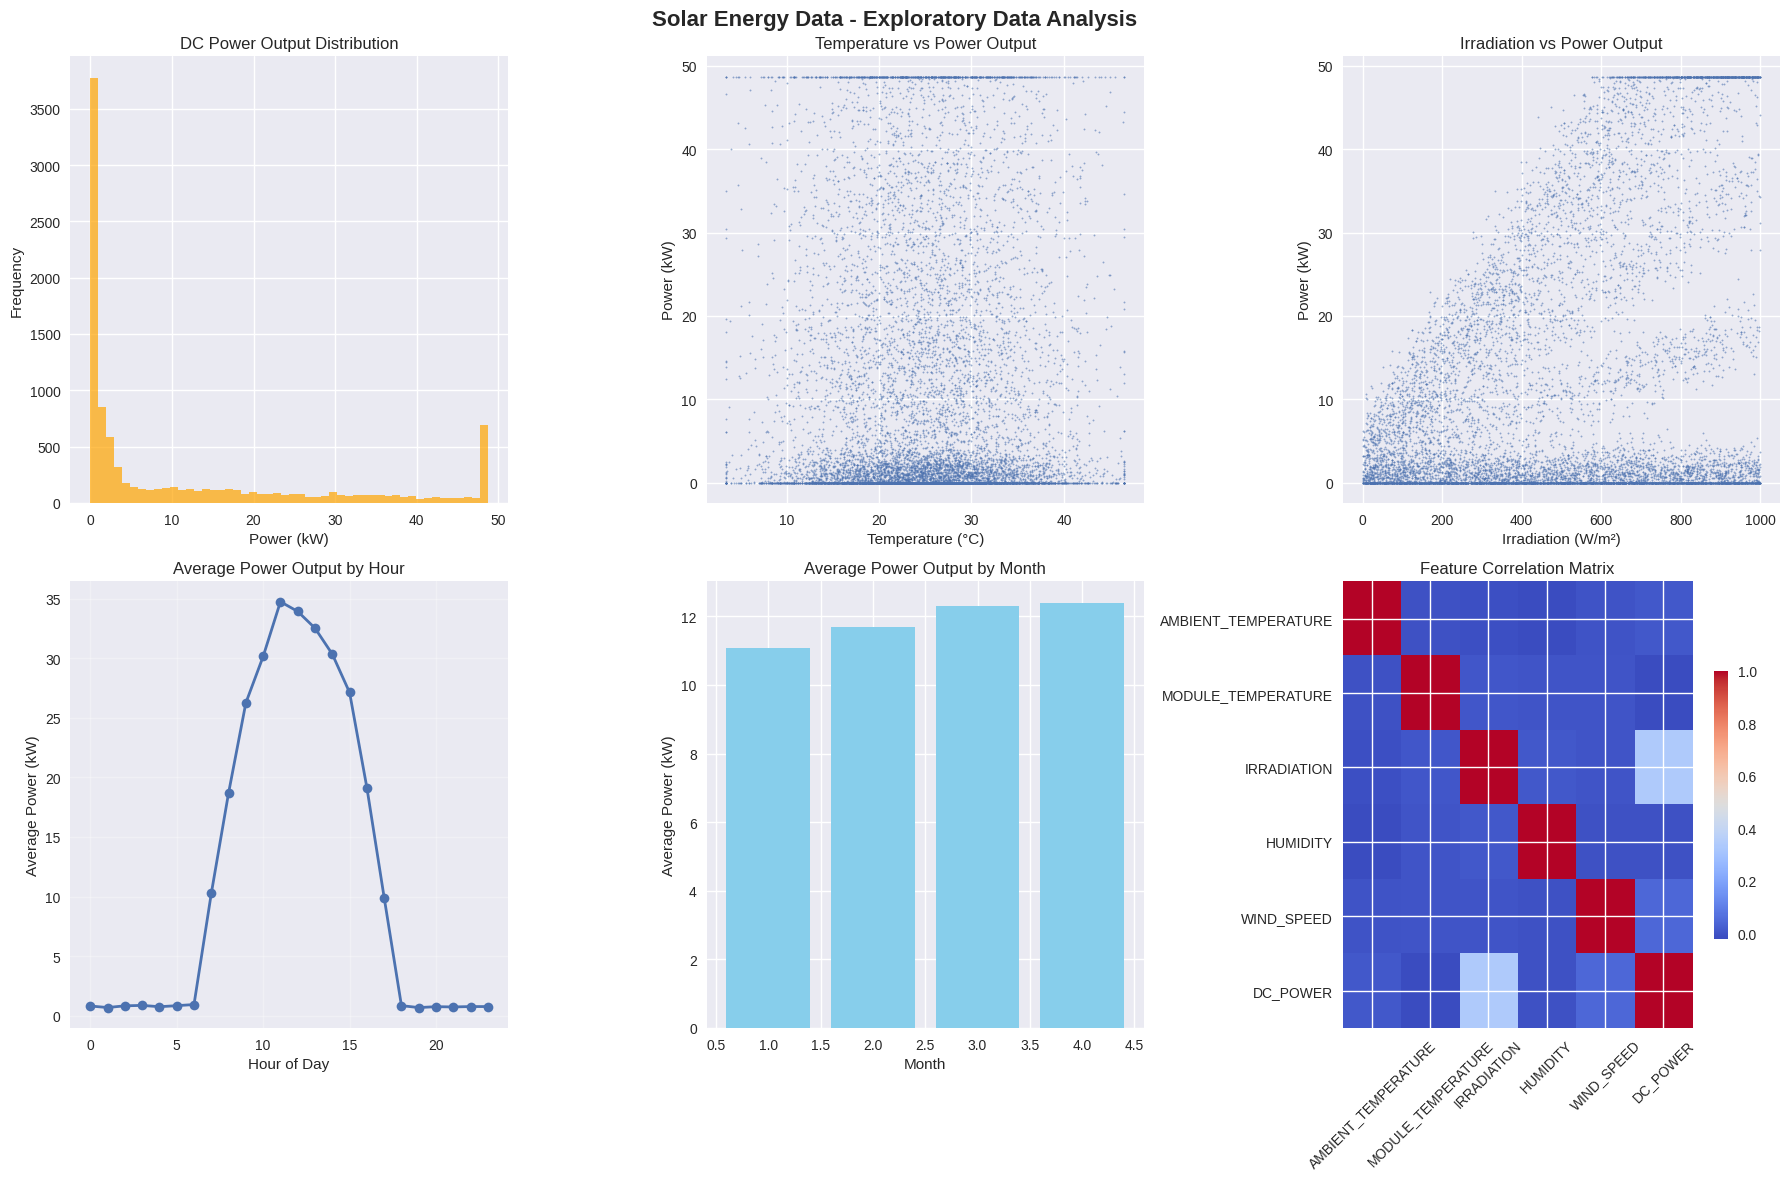


Key Correlations with DC_POWER:
IRRADIATION: 0.338
WIND_SPEED: 0.045
AMBIENT_TEMPERATURE: 0.010
HUMIDITY: -0.004
MODULE_TEMPERATURE: -0.019
Performing feature engineering...
Feature engineering completed. New shape: (10000, 30)
Training models...
Training Linear Regression models...
Training Random Forest...
Training XGBoost...
Training Neural Network...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Best model: XGBoost
Best RMSE: 1.642

Model Evaluation Results:
                 RMSE     R2
XGBoost         1.642  0.989
Random Forest   1.711  0.988
Neural Network  2.111  0.982
Ridge           8.214  0.726
Lasso           8.237  0.725


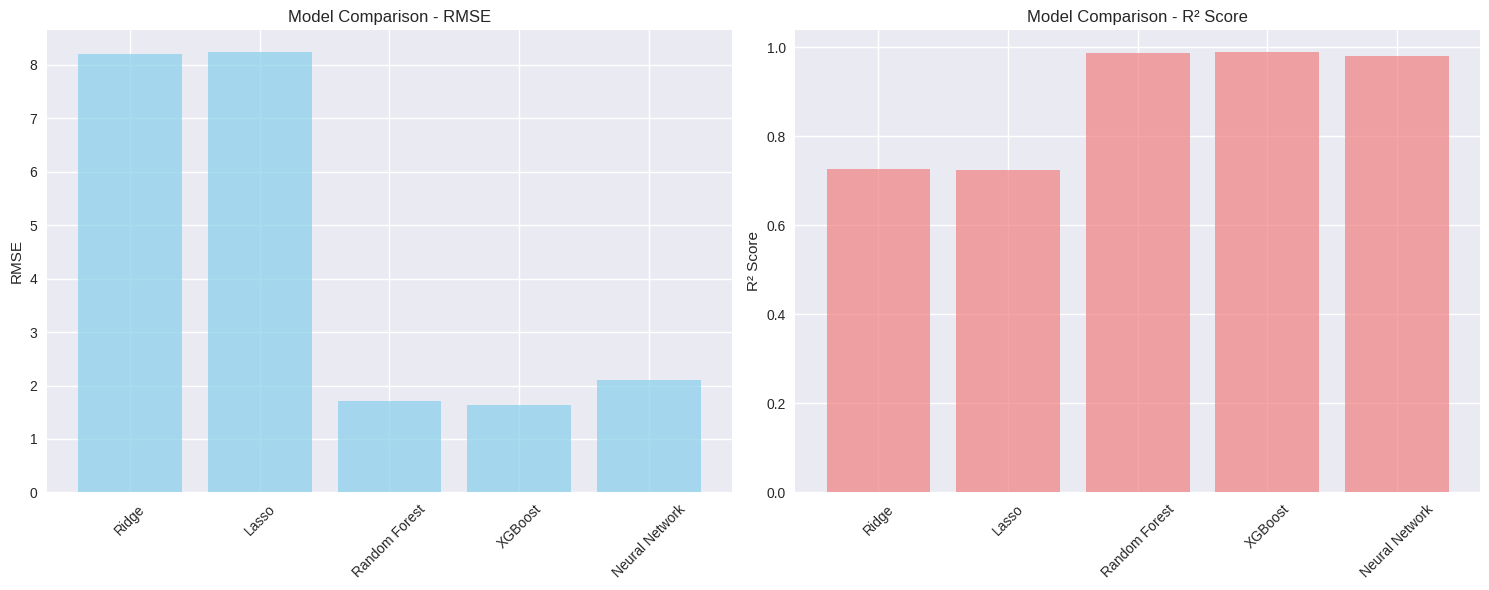


Feature Importance Analysis:

Random Forest Feature Importance:
                Feature  Importance
14             HOUR_COS    0.708951
2           IRRADIATION    0.142026
21  IRRADIATION_SQUARED    0.135318
12           IRRAD_WIND    0.006860
7           DAY_OF_YEAR    0.002307
4            WIND_SPEED    0.000975
24   IRRAD_ROLLING_MEAN    0.000431
23    TEMP_ROLLING_MEAN    0.000406
1    MODULE_TEMPERATURE    0.000394
3              HUMIDITY    0.000355


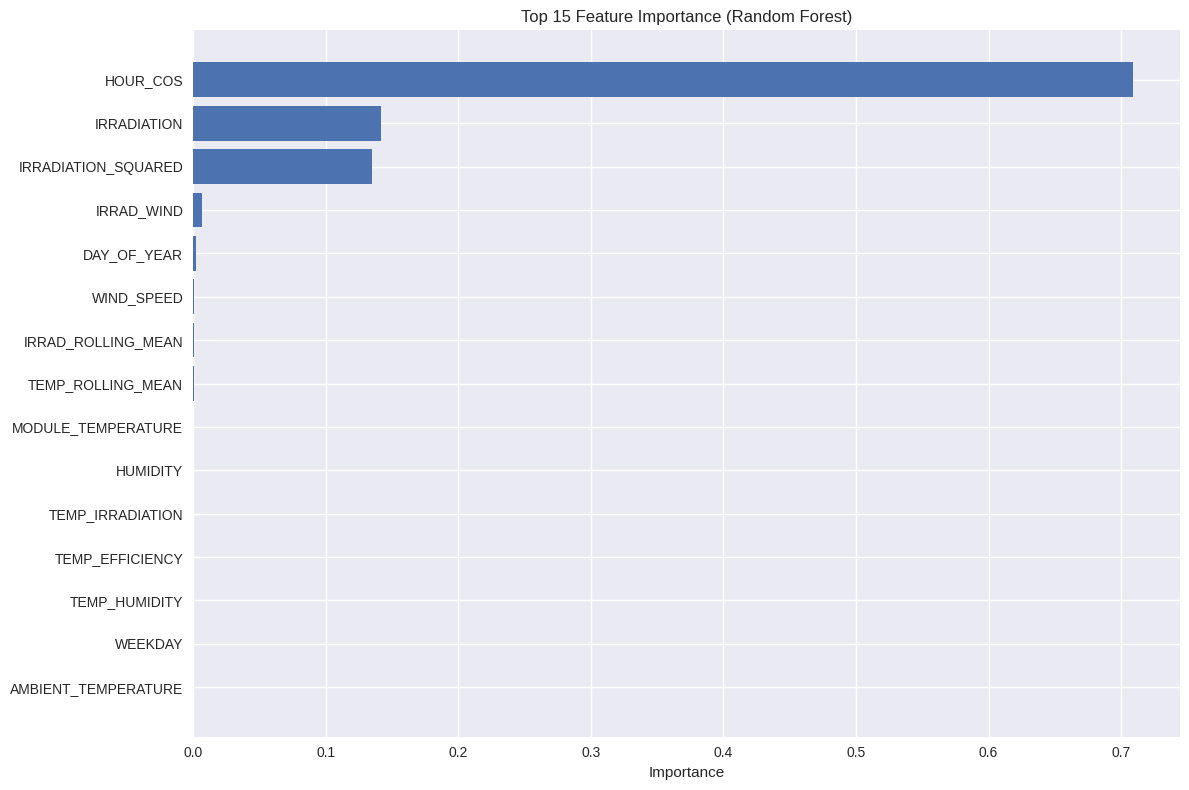


XGBoost Feature Importance:
             Feature  Importance
14          HOUR_COS    0.757427
2        IRRADIATION    0.220470
12        IRRAD_WIND    0.008468
6              MONTH    0.003104
7        DAY_OF_YEAR    0.002399
4         WIND_SPEED    0.001015
10  TEMP_IRRADIATION    0.000976
11     TEMP_HUMIDITY    0.000708
20   TEMP_EFFICIENCY    0.000652
15         MONTH_SIN    0.000616
Models saved to models/

SOLAR ENERGY PRODUCTION PREDICTION - ANALYSIS REPORT

Best Performing Model: XGBoost
RMSE: 1.642
R² Score: 0.989

SDG 7 IMPACT ASSESSMENT:
-------------------------
✅ HIGH IMPACT: Model achieves >85% accuracy
   - Enables precise solar energy planning
   - Optimizes renewable energy investments
   - Reduces fossil fuel dependency

Model Performance Summary:
- Prediction Accuracy: 98.9%
- Average Error: 1.64 kW

✅ Pipeline completed successfully!
Models saved and ready for deployment in Streamlit dashboard.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import warnings
warnings.filterwarnings('ignore')

class SolarEnergyMLPipeline:

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_names = []
        self.best_model = None
        self.best_model_name = None
        self.results = {}

    def load_data(self, file_path=None):
        """Load solar power data from CSV or generate synthetic data"""
        if file_path:
            # Load from Kaggle dataset
            df = pd.read_csv(file_path)
        else:
            # Generate synthetic data for demonstration
            df = self._generate_synthetic_data()

        print(f"Data loaded successfully. Shape: {df.shape}")
        return df

    def _generate_synthetic_data(self, n_samples=10000):
        """Generate synthetic solar power data based on realistic patterns"""
        np.random.seed(42)

        # Generate time series
        start_date = pd.Timestamp('2020-01-01')
        dates = pd.date_range(start_date, periods=n_samples, freq='15min')

        # Base weather patterns
        df = pd.DataFrame({
            'DATE_TIME': dates,
            'AMBIENT_TEMPERATURE': np.random.normal(25, 8, n_samples),
            'MODULE_TEMPERATURE': np.random.normal(35, 10, n_samples),
            'IRRADIATION': np.random.uniform(0, 1000, n_samples),
            'HUMIDITY': np.random.uniform(20, 80, n_samples),
            'WIND_SPEED': np.random.uniform(0, 15, n_samples)
        })

        # Add temporal features
        df['HOUR'] = df['DATE_TIME'].dt.hour
        df['MONTH'] = df['DATE_TIME'].dt.month
        df['DAY_OF_YEAR'] = df['DATE_TIME'].dt.dayofyear
        df['SEASON'] = df['MONTH'].apply(self._get_season)

        # Generate realistic power output
        df['DC_POWER'] = self._generate_power_output(df)
        df['AC_POWER'] = df['DC_POWER'] * np.random.uniform(0.92, 0.98, n_samples)

        return df

    def _get_season(self, month):
        """Convert month to season"""
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    def _generate_power_output(self, df):
        """Generate realistic power output based on weather conditions"""
        # Base power from irradiation (primary factor)
        base_power = df['IRRADIATION'] * 0.06

        # Temperature effect (optimal around 25°C)
        temp_effect = -0.3 * (df['AMBIENT_TEMPERATURE'] - 25) ** 2 / 100

        # Humidity effect (higher humidity reduces efficiency)
        humidity_effect = -0.1 * (df['HUMIDITY'] - 50) / 50

        # Wind effect (positive cooling effect)
        wind_effect = 0.5 * df['WIND_SPEED']

        # Seasonal patterns
        seasonal_factor = 1 + 0.2 * np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 365)

        # Daily patterns (sun angle effect)
        daily_factor = np.maximum(0, np.sin(np.pi * (df['HOUR'] - 6) / 12))

        # Combine all effects
        power = (base_power + temp_effect + humidity_effect + wind_effect) * seasonal_factor * daily_factor

        # Add realistic noise
        noise = np.random.normal(0, 2, len(df))
        power += noise

        # Ensure non-negative power
        return np.maximum(power, 0)

    def data_wrangling(self, df):
        """Comprehensive data cleaning and preprocessing"""
        print("Starting data wrangling...")

        # Handle missing values
        print(f"Missing values before cleaning:\n{df.isnull().sum()}")

        # Impute missing values
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].median(), inplace=True)

        # Handle outliers using IQR method
        for col in ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER']:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
                df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
                print(f"Outliers handled in {col}: {outliers_before}")

        # Convert datetime
        if 'DATE_TIME' in df.columns:
            df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

        print("Data wrangling completed successfully!")
        return df

    def exploratory_data_analysis(self, df):
        """Comprehensive EDA with visualizations"""
        print("Performing Exploratory Data Analysis...")

        # Basic statistics
        print("\nDataset Overview:")
        print(f"Shape: {df.shape}")
        print(f"Data types:\n{df.dtypes}")
        print(f"\nBasic statistics:\n{df.describe()}")

        # Set up plotting style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Solar Energy Data - Exploratory Data Analysis', fontsize=16, fontweight='bold')

        # 1. Power output distribution
        axes[0, 0].hist(df['DC_POWER'], bins=50, alpha=0.7, color='orange')
        axes[0, 0].set_title('DC Power Output Distribution')
        axes[0, 0].set_xlabel('Power (kW)')
        axes[0, 0].set_ylabel('Frequency')

        # 2. Temperature vs Power
        axes[0, 1].scatter(df['AMBIENT_TEMPERATURE'], df['DC_POWER'], alpha=0.5, s=1)
        axes[0, 1].set_title('Temperature vs Power Output')
        axes[0, 1].set_xlabel('Temperature (°C)')
        axes[0, 1].set_ylabel('Power (kW)')

        # 3. Irradiation vs Power
        axes[0, 2].scatter(df['IRRADIATION'], df['DC_POWER'], alpha=0.5, s=1)
        axes[0, 2].set_title('Irradiation vs Power Output')
        axes[0, 2].set_xlabel('Irradiation (W/m²)')
        axes[0, 2].set_ylabel('Power (kW)')

        # 4. Hourly power patterns
        hourly_avg = df.groupby('HOUR')['DC_POWER'].mean()
        axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
        axes[1, 0].set_title('Average Power Output by Hour')
        axes[1, 0].set_xlabel('Hour of Day')
        axes[1, 0].set_ylabel('Average Power (kW)')
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Monthly patterns
        monthly_avg = df.groupby('MONTH')['DC_POWER'].mean()
        axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='skyblue')
        axes[1, 1].set_title('Average Power Output by Month')
        axes[1, 1].set_xlabel('Month')
        axes[1, 1].set_ylabel('Average Power (kW)')

        # 6. Correlation heatmap
        correlation_cols = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
                           'HUMIDITY', 'WIND_SPEED', 'DC_POWER']
        corr_matrix = df[correlation_cols].corr()
        im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        axes[1, 2].set_xticks(range(len(correlation_cols)))
        axes[1, 2].set_yticks(range(len(correlation_cols)))
        axes[1, 2].set_xticklabels(correlation_cols, rotation=45)
        axes[1, 2].set_yticklabels(correlation_cols)
        axes[1, 2].set_title('Feature Correlation Matrix')

        # Add colorbar
        plt.colorbar(im, ax=axes[1, 2], shrink=0.6)

        plt.tight_layout()
        plt.show()

        # Print correlation insights
        print("\nKey Correlations with DC_POWER:")
        power_corr = df[correlation_cols].corr()['DC_POWER'].sort_values(ascending=False)
        for feature, corr in power_corr.items():
            if feature != 'DC_POWER':
                print(f"{feature}: {corr:.3f}")

    def feature_engineering(self, df):
        """Advanced feature engineering"""
        print("Performing feature engineering...")

        # Temporal features
        df['HOUR'] = df['DATE_TIME'].dt.hour
        df['MONTH'] = df['DATE_TIME'].dt.month
        df['DAY_OF_YEAR'] = df['DATE_TIME'].dt.dayofyear
        df['WEEKDAY'] = df['DATE_TIME'].dt.weekday
        df['QUARTER'] = df['DATE_TIME'].dt.quarter

        # Interaction features
        df['TEMP_IRRADIATION'] = df['AMBIENT_TEMPERATURE'] * df['IRRADIATION']
        df['TEMP_HUMIDITY'] = df['AMBIENT_TEMPERATURE'] * df['HUMIDITY']
        df['IRRAD_WIND'] = df['IRRADIATION'] * df['WIND_SPEED']

        # Cyclical features (for better temporal modeling)
        df['HOUR_SIN'] = np.sin(2 * np.pi * df['HOUR'] / 24)
        df['HOUR_COS'] = np.cos(2 * np.pi * df['HOUR'] / 24)
        df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
        df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

        # Binary features
        df['IS_DAYTIME'] = ((df['HOUR'] >= 6) & (df['HOUR'] <= 18)).astype(int)
        df['IS_SUMMER'] = df['MONTH'].isin([6, 7, 8]).astype(int)
        df['IS_WEEKEND'] = (df['WEEKDAY'] >= 5).astype(int)

        # Efficiency-related features
        df['EFFICIENCY_RATIO'] = df['DC_POWER'] / (df['IRRADIATION'] + 1e-6)
        df['TEMP_EFFICIENCY'] = df['AMBIENT_TEMPERATURE'] / (df['MODULE_TEMPERATURE'] + 1e-6)

        # Polynomial features for non-linear relationships
        df['IRRADIATION_SQUARED'] = df['IRRADIATION'] ** 2
        df['TEMP_SQUARED'] = df['AMBIENT_TEMPERATURE'] ** 2

        # Rolling statistics (for time series patterns)
        df['TEMP_ROLLING_MEAN'] = df['AMBIENT_TEMPERATURE'].rolling(window=10).mean()
        df['IRRAD_ROLLING_MEAN'] = df['IRRADIATION'].rolling(window=10).mean()

        # Fill NaN values from rolling calculations
        df['TEMP_ROLLING_MEAN'].fillna(df['AMBIENT_TEMPERATURE'], inplace=True)
        df['IRRAD_ROLLING_MEAN'].fillna(df['IRRADIATION'], inplace=True)

        print(f"Feature engineering completed. New shape: {df.shape}")
        return df

    def prepare_features(self, df):
        """Prepare features for modeling"""
        # Define feature columns
        feature_columns = [
            'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
            'HUMIDITY', 'WIND_SPEED', 'HOUR', 'MONTH', 'DAY_OF_YEAR',
            'WEEKDAY', 'QUARTER', 'TEMP_IRRADIATION', 'TEMP_HUMIDITY',
            'IRRAD_WIND', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS',
            'IS_DAYTIME', 'IS_SUMMER', 'IS_WEEKEND', 'TEMP_EFFICIENCY',
            'IRRADIATION_SQUARED', 'TEMP_SQUARED', 'TEMP_ROLLING_MEAN',
            'IRRAD_ROLLING_MEAN'
        ]

        # Filter available features
        available_features = [col for col in feature_columns if col in df.columns]
        self.feature_names = available_features

        X = df[available_features]
        y = df['DC_POWER']

        return X, y

    def train_models(self, X, y):
        """Train multiple models with hyperparameter tuning"""
        print("Training models...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['standard'] = scaler

        # 1. Linear Regression with Regularization
        print("Training Linear Regression models...")

        # Ridge Regression
        ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
        ridge = Ridge()
        ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
        ridge_grid.fit(X_train_scaled, y_train)

        ridge_pred = ridge_grid.predict(X_test_scaled)
        ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
        ridge_r2 = r2_score(y_test, ridge_pred)

        self.models['Ridge'] = ridge_grid.best_estimator_
        self.results['Ridge'] = {'RMSE': ridge_rmse, 'R2': ridge_r2}

        # Lasso Regression
        lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
        lasso = Lasso()
        lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
        lasso_grid.fit(X_train_scaled, y_train)

        lasso_pred = lasso_grid.predict(X_test_scaled)
        lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
        lasso_r2 = r2_score(y_test, lasso_pred)

        self.models['Lasso'] = lasso_grid.best_estimator_
        self.results['Lasso'] = {'RMSE': lasso_rmse, 'R2': lasso_r2}

        # 2. Random Forest
        print("Training Random Forest...")

        rf_params = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        rf = RandomForestRegressor(random_state=42)
        rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        rf_grid.fit(X_train, y_train)

        rf_pred = rf_grid.predict(X_test)
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
        rf_r2 = r2_score(y_test, rf_pred)

        self.models['Random Forest'] = rf_grid.best_estimator_
        self.results['Random Forest'] = {'RMSE': rf_rmse, 'R2': rf_r2}

        # 3. XGBoost
        print("Training XGBoost...")

        xgb_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }

        xgb_model = xgb.XGBRegressor(random_state=42)
        xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        xgb_grid.fit(X_train, y_train)

        xgb_pred = xgb_grid.predict(X_test)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
        xgb_r2 = r2_score(y_test, xgb_pred)

        self.models['XGBoost'] = xgb_grid.best_estimator_
        self.results['XGBoost'] = {'RMSE': xgb_rmse, 'R2': xgb_r2}

        # 4. Neural Network
        print("Training Neural Network...")

        # Build neural network
        nn_model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1, activation='linear')
        ])

        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

        # Train neural network
        history = nn_model.fit(
            X_train_scaled, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        nn_pred = nn_model.predict(X_test_scaled).flatten()
        nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
        nn_r2 = r2_score(y_test, nn_pred)

        self.models['Neural Network'] = nn_model
        self.results['Neural Network'] = {'RMSE': nn_rmse, 'R2': nn_r2}

        # Select best model
        best_rmse = float('inf')
        for name, metrics in self.results.items():
            if metrics['RMSE'] < best_rmse:
                best_rmse = metrics['RMSE']
                self.best_model_name = name
                self.best_model = self.models[name]

        print(f"\nBest model: {self.best_model_name}")
        print(f"Best RMSE: {best_rmse:.3f}")

        return X_test, y_test

    def evaluate_models(self):
        """Evaluate and compare all models"""
        print("\nModel Evaluation Results:")
        print("=" * 50)

        results_df = pd.DataFrame(self.results).T
        results_df = results_df.sort_values('RMSE')

        print(results_df.round(3))

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # RMSE comparison
        models = list(self.results.keys())
        rmse_values = [self.results[model]['RMSE'] for model in models]
        r2_values = [self.results[model]['R2'] for model in models]

        ax1.bar(models, rmse_values, color='skyblue', alpha=0.7)
        ax1.set_title('Model Comparison - RMSE')
        ax1.set_ylabel('RMSE')
        ax1.tick_params(axis='x', rotation=45)

        # R² comparison
        ax2.bar(models, r2_values, color='lightcoral', alpha=0.7)
        ax2.set_title('Model Comparison - R² Score')
        ax2.set_ylabel('R² Score')
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        return results_df

    def feature_importance_analysis(self):
        """Analyze feature importance for tree-based models"""
        print("\nFeature Importance Analysis:")
        print("=" * 40)

        # Random Forest feature importance
        if 'Random Forest' in self.models:
            rf_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': self.models['Random Forest'].feature_importances_
            }).sort_values('Importance', ascending=False)

            print("\nRandom Forest Feature Importance:")
            print(rf_importance.head(10))

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            top_features = rf_importance.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'])
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance')
            plt.title('Top 15 Feature Importance (Random Forest)')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

        # XGBoost feature importance
        if 'XGBoost' in self.models:
            xgb_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': self.models['XGBoost'].feature_importances_
            }).sort_values('Importance', ascending=False)

            print("\nXGBoost Feature Importance:")
            print(xgb_importance.head(10))

    def save_models(self, directory='models'):
        """Save trained models and scalers"""
        import os
        os.makedirs(directory, exist_ok=True)

        # Save best model
        if self.best_model_name != 'Neural Network':
            joblib.dump(self.best_model, f'{directory}/best_model.pkl')
        else:
            self.best_model.save(f'{directory}/best_model.h5')

        # Save all models
        for name, model in self.models.items():
            if name != 'Neural Network':
                joblib.dump(model, f'{directory}/{name.lower().replace(" ", "_")}.pkl')
            else:
                model.save(f'{directory}/neural_network.h5')

        # Save scalers
        joblib.dump(self.scalers, f'{directory}/scalers.pkl')

        # Save feature names
        joblib.dump(self.feature_names, f'{directory}/feature_names.pkl')

        # Save results
        results_df = pd.DataFrame(self.results).T
        results_df.to_csv(f'{directory}/model_results.csv')

        print(f"Models saved to {directory}/")

    def predict(self, X_new):
        """Make predictions using the best model"""
        if self.best_model is None:
            raise ValueError("No trained model available. Please train models first.")

        # Prepare features
        if self.best_model_name in ['Ridge', 'Lasso', 'Neural Network']:
            X_scaled = self.scalers['standard'].transform(X_new)
            predictions = self.best_model.predict(X_scaled)
        else:
            predictions = self.best_model.predict(X_new)

        if self.best_model_name == 'Neural Network':
            predictions = predictions.flatten()

        return predictions

    def generate_report(self):
        """Generate comprehensive analysis report"""
        print("\n" + "="*60)
        print("SOLAR ENERGY PRODUCTION PREDICTION - ANALYSIS REPORT")
        print("="*60)

        print(f"\nBest Performing Model: {self.best_model_name}")
        print(f"RMSE: {self.results[self.best_model_name]['RMSE']:.3f}")
        print(f"R² Score: {self.results[self.best_model_name]['R2']:.3f}")

        # SDG Impact Assessment
        print("\nSDG 7 IMPACT ASSESSMENT:")
        print("-" * 25)
        r2_score = self.results[self.best_model_name]['R2']

        if r2_score > 0.85:
            print("✅ HIGH IMPACT: Model achieves >85% accuracy")
            print("   - Enables precise solar energy planning")
            print("   - Optimizes renewable energy investments")
            print("   - Reduces fossil fuel dependency")
        elif r2_score > 0.7:
            print("🟡 MODERATE IMPACT: Model achieves 70-85% accuracy")
            print("   - Supports basic solar energy planning")
            print("   - Provides general renewable energy insights")
        else:
            print("❌ LOW IMPACT: Model accuracy below 70%")
            print("   - Requires model improvement for practical use")

        print(f"\nModel Performance Summary:")
        print(f"- Prediction Accuracy: {r2_score*100:.1f}%")
        print(f"- Average Error: {self.results[self.best_model_name]['RMSE']:.2f} kW")

        return self.results

# Example usage and demonstration
def main():
    """Main function to demonstrate the complete pipeline"""
    print("Solar Energy Production Prediction System")
    print("Supporting SDG 7: Affordable and Clean Energy")
    print("="*50)

    # Initialize pipeline
    pipeline = SolarEnergyMLPipeline()

    # Load data (using synthetic data for demonstration)
    df = pipeline.load_data()

    # Data wrangling
    df = pipeline.data_wrangling(df)

    # EDA
    pipeline.exploratory_data_analysis(df)

    # Feature engineering
    df = pipeline.feature_engineering(df)

    # Prepare features
    X, y = pipeline.prepare_features(df)

    # Train models
    X_test, y_test = pipeline.train_models(X, y)

    # Evaluate models
    results_df = pipeline.evaluate_models()

    # Feature importance analysis
    pipeline.feature_importance_analysis()

    # Save models
    pipeline.save_models()

    # Generate report
    pipeline.generate_report()

    print("\n✅ Pipeline completed successfully!")
    print("Models saved and ready for deployment in Streamlit dashboard.")

if __name__ == "__main__":
    main()